Setting up imports

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score
from torchvision.transforms import transforms

from example.efficient_net_b0_finetuned import EfficientNetB0FineTuned
from example.models import CNNModel, CNNModel2, CNNModel3
from example.datasets import FashionMNISTDataset

Adding custom hyper-parameters

In [2]:
learning_rate = 0.15
momentum = 0.9
num_epochs = 20

Set up a device for pytorch calculations

In [3]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading datasets, training dataset from kaggle and test dataset from kaggle

In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,), (0.5,)),
])

train_dataloader = torch.utils.data.DataLoader(dataset=FashionMNISTDataset(file="model_data/fashion-mnist_train.csv"),
                                               batch_size=1028, pin_memory=True, num_workers=8)
train_dataloader_with_transform = torch.utils.data.DataLoader(
    dataset=FashionMNISTDataset(file="model_data/fashion-mnist_train.csv", transform=transform), batch_size=256,
    pin_memory=True, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(dataset=FashionMNISTDataset(file="model_data/fashion-mnist_test.csv"),
                                              batch_size=1028, pin_memory=True, num_workers=8)
test_dataloader_with_transform = torch.utils.data.DataLoader(
    dataset=FashionMNISTDataset(file="model_data/fashion-mnist_test.csv", transform=transform), batch_size=256,
    pin_memory=True, num_workers=8)

Model training method where we update loss each epoch and X_train record

In [5]:
def train_model(model_, loss_each_epoch, loss_fun, train_dataloader_, print_loss=False):
    for epoch in range(num_epochs):
        model_["model"].train()
        running_loss = 0.0

        for images, labels in train_dataloader_:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model_["model"](images)
            loss = loss_fun(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        loss_each_epoch.append(running_loss)
        if print_loss:
            print(f"Model {model["name"]}, epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss:.4f}")

We compare all of our models to check which one is performing the best, we plot
data of loss over epochs

Model relu, conv2d and maxpool, epoch [1/20], Loss: 122.3659
Model relu, conv2d and maxpool, epoch [2/20], Loss: 51.2028
Model relu, conv2d and maxpool, epoch [3/20], Loss: 33.0394
Model relu, conv2d and maxpool, epoch [4/20], Loss: 29.4071
Model relu, conv2d and maxpool, epoch [5/20], Loss: 27.0811
Model relu, conv2d and maxpool, epoch [6/20], Loss: 25.5364
Model relu, conv2d and maxpool, epoch [7/20], Loss: 23.9701
Model relu, conv2d and maxpool, epoch [8/20], Loss: 23.3206
Model relu, conv2d and maxpool, epoch [9/20], Loss: 22.2365
Model relu, conv2d and maxpool, epoch [10/20], Loss: 21.7513
Model relu, conv2d and maxpool, epoch [11/20], Loss: 20.9713
Model relu, conv2d and maxpool, epoch [12/20], Loss: 20.5132
Model relu, conv2d and maxpool, epoch [13/20], Loss: 20.2405
Model relu, conv2d and maxpool, epoch [14/20], Loss: 19.6198
Model relu, conv2d and maxpool, epoch [15/20], Loss: 19.1801
Model relu, conv2d and maxpool, epoch [16/20], Loss: 18.9374
Model relu, conv2d and maxpool, 

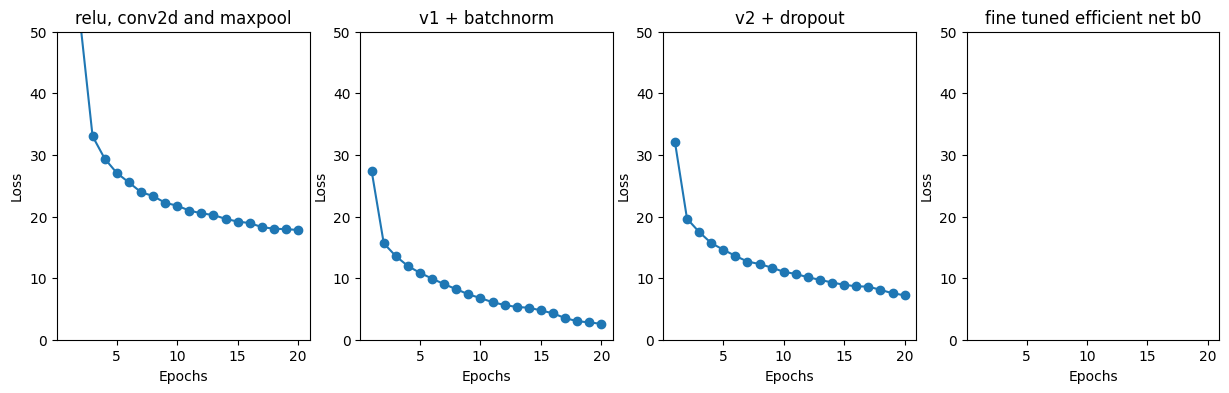

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [6]:
models = [
    {"model": CNNModel(), "name": "relu, conv2d and maxpool"},
    {"model": CNNModel2(), "name": "v1 + batchnorm"},
    {"model": CNNModel3(), "name": "v2 + dropout"},
    {"model": EfficientNetB0FineTuned(), "name": "fine tuned efficient net b0"},
]
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

for idx, model in enumerate(models):
    model_loss_each_epoch = []
    model["model"].to(device)
    optimizer = torch.optim.SGD(model["model"].parameters(), lr=learning_rate, momentum=momentum)
    dataloader = train_dataloader if idx != 3 else train_dataloader_with_transform
    criterion = nn.CrossEntropyLoss()
    train_model(model_=model, loss_fun=criterion, loss_each_epoch=model_loss_each_epoch, train_dataloader_=dataloader, print_loss=True)

    epochs = list(range(1, num_epochs + 1))
    plt.figure(figsize=(8, 5))
    axes[idx].set_title(model["name"])
    axes[idx].plot(epochs, model_loss_each_epoch, marker='o')
    axes[idx].set_ylim(0, 50)
    axes[idx].set_xlabel('Epochs')
    axes[idx].set_ylabel('Loss')

plt.tight_layout()
plt.show()

We are checking model accuracy basing on test dataset

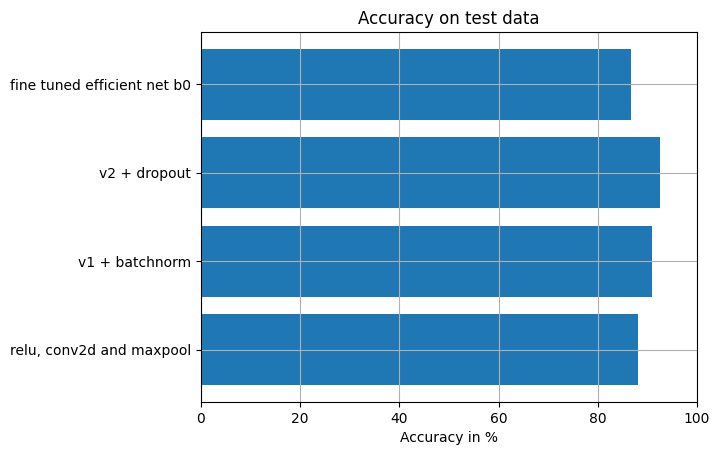

In [7]:
models_accuracy = []
models_predictions = [[], [], [], []]
models_all_labels = [[], [], [], []]

for idx, model in enumerate(models):
    correct = 0
    total = 0
    model["model"].eval()
    with torch.no_grad():
        dataloader = test_dataloader if idx != 3 else test_dataloader_with_transform
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model["model"](images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            models_predictions[idx].append(predicted.cpu().numpy())
            models_all_labels[idx].append(labels.cpu().numpy())
    accuracy = 100 * correct / total
    models_accuracy.append(accuracy)

plt.barh([model["name"] for model in models], models_accuracy)
plt.title("Accuracy on test data")
plt.xlabel("Accuracy in %")
plt.xlim(0, 100)
plt.grid()
plt.show()

Viewing models correct answers and mistakes on sklearn ConfusionMatrix

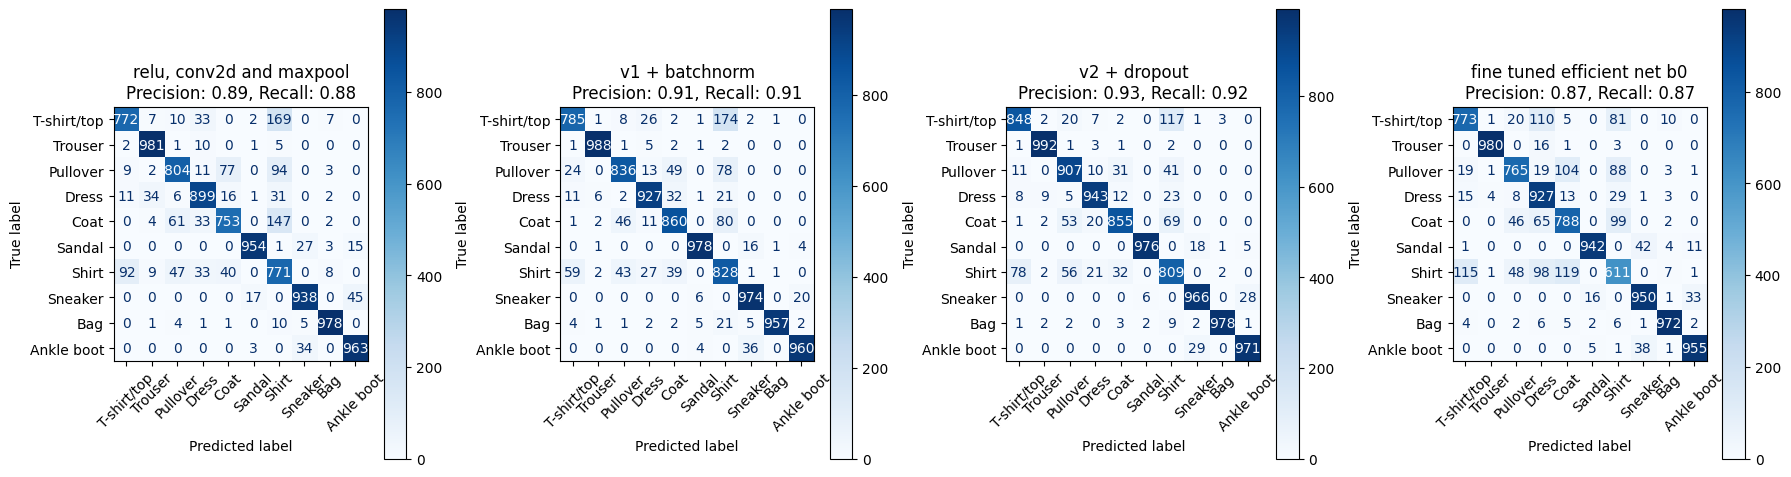

In [8]:

label_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for idx, _ in enumerate(models):
    y_true = np.concatenate(models_all_labels[idx])
    y_pred = np.concatenate(models_predictions[idx])

    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_names[i] for i in range(10)])
    disp.plot(cmap='Blues', ax=axes[idx], xticks_rotation=45)
    axes[idx].set_title(f"{models[idx]["name"]}\nPrecision: {precision:.2f}, Recall: {recall:.2f}")

plt.tight_layout()
plt.show()
